In [46]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
from lrg_plot_functions import *
from lrg_sum_functions import *
from cosmo_Calc import *
from divideByTwo import *
from read_data import *
from nearNeighbors import *
from scipy import stats
from astropy import stats
import healpy as hp
from localBKG_and_interlopersHEALPix import *
# import healpy as hpy
from makeCutoutTableFunc import *
from plotHistogramProjections3D import *
from read_bricks import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random

In [47]:
ra_dat3 = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/raBKG_bin3-dr9.npz')
ra_BKG3 = ra_dat3['arr_0']
print(len(ra_BKG3))
print('ra done')

dec_dat3 = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/decBKG_bin3-dr9.npz')
dec_BKG3 = dec_dat3['arr_0']
print(len(dec_BKG3))
print('dec done')

galdepth_dat3 = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/galdepth_z_BKG_bin3-dr9.npz')
galdepth_BKG3 = galdepth_dat3['arr_0']
print(len(galdepth_BKG3))
print('zmag done')



ra_dat3a = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/raBKG_320to330-dr9.npz')
ra_BKG3a = ra_dat3a['arr_0']
print(len(ra_BKG3a))
print('ra done')

dec_dat3a = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/decBKG_320to330-dr9.npz')
dec_BKG3a = dec_dat3a['arr_0']
print(len(dec_BKG3a))
print('dec done')

zmag_dat3a = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/galdepth_z_BKG_320to330-dr9.npz')
galdepth_BKG3a = zmag_dat3a['arr_0']
print(len(galdepth_BKG3a))
print('zmag done')


ra_dat3b = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/raBKG_330to340-dr9.npz')
ra_BKG3b = ra_dat3b['arr_0']
print(len(ra_BKG3b))
print('ra done')

dec_dat3b = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/decBKG_330to340-dr9.npz')
dec_BKG3b = dec_dat3b['arr_0']
print(len(dec_BKG3b))
print('dec done')

zmag_dat3b = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/galdepth_z_BKG_330to340-dr9.npz')
galdepth_BKG3b = zmag_dat3b['arr_0']
print(len(galdepth_BKG3b))
print('zmag done')


ra_dat3c = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/raBKG_350to360-dr9.npz')
ra_BKG3c = ra_dat3c['arr_0']
print(len(ra_BKG3c))
print('ra done')

dec_dat3c = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/decBKG_350to360-dr9.npz')
dec_BKG3c = dec_dat3c['arr_0']
print(len(dec_BKG3c))
print('dec done')

zmag_dat3c = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/galdepth_z_BKG_350to360-dr9.npz')
galdepth_BKG3c = zmag_dat3c['arr_0']
print(len(galdepth_BKG3c))
print('zmag done')



91891067
ra done
91891067
dec done
91891067
zmag done
11801610
ra done
11801610
dec done
11801610
zmag done
7173047
ra done
7173047
dec done
7173047
zmag done
16289256
ra done
16289256
dec done
16289256
zmag done


In [41]:
# Make HEALPix map using just RA/Dec; end up with a density plot

nside = 1024
npixel = hp.nside2npix(nside)

# ra_cut = ra[np.where(zmag <= 21.5)]
# dec_cut = dec[np.where(zmag <= 21.5)]

# Convert ra/dec into theta/phi
theta = []
phi = []

for i in range(len(ra_BKG3c)):
    theta.append(np.radians(90. - dec_BKG3c[i]))
    phi.append(np.radians(ra_BKG3c[i]))

print('length phi: ', len(phi))
# Convert angles theta and phi to pixel numbers
pixnums = hp.ang2pix(nside, theta, phi, nest=True)
print('pixnums: ', pixnums)
print(pixnums[0])
print('length pixnums: ', len(pixnums))


# Create a HEALPix map from pix
mapp = np.bincount(pixnums, minlength=npixel)
# print('map where ne 0: ', mapp[np.where(mapp > 0)])
# print('length map == 0: ', len(mapp[np.where(mapp == 0)]))
# print('length map: ', len(mapp))

# masked_map = np.zeros(len(mapp))
# masked_map[(mapp == 0)] = 1

# m = hp.ma(mapp)
# m.mask = masked_map



length phi:  16289256
pixnums:  [4803286 4803287 4803464 ... 5125396 5119929 5119931]
4803286
length pixnums:  16289256


52.366867267221544 127.63313273277844 -37.633132732778456 37.633132732778456
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 10 deg 0.00'.


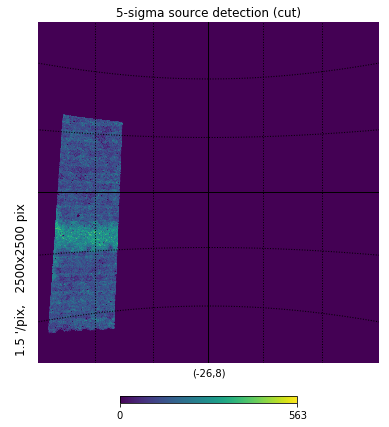

In [46]:
# Plot mapp
# hp.gnomview(mapp, xsize=225, ysize=225, rot=(-116.5, 9.), flip='geo', nest=True, title='Density Map (nobs >= 2)')
hp.gnomview(mapp, flip='astro', xsize=2500, rot=(-26., 8.), nest=True, title='5-sigma source detection (cut)')
hp.graticule(dpar=10.)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/08April2021/HEALPix-320to330.pdf')
plt.show()

In [26]:
# hp.mollview(mapp, flip='astro', nest=True, title='Density Map')
# hp.graticule(dpar=10.)
# plt.show()

In [42]:
# This section maps various values of the galaxies into a HEALPix map so the result is basically a density map of
# galaxy properties. In this code the new maps are array_g, array_r, and array_z.

# returns indices that would sort the array pixnums
pixorder = np.argsort(pixnums)
# returns sorted unique values of pixnums, indices to reconstruct the original array from the unique array,
# and the number of times each unique value comes up in the original array
pixels, pixinverse, pixcnts = np.unique(pixnums, return_inverse=True, return_counts=True)

# print(len(pixnums))
# print('----')
# print(pixorder)
# print('----')
# print(len(pixels))
# print('----')
# print(pixcnts)
# inserts a zero in the zeroth index space, moving all other values down the line
pixcnts = np.insert(pixcnts, 0, 0)
# calculates the cumulative sum of the values in pixcnts
pixcnts = np.cumsum(pixcnts)
# print(pixcnts)

# This seems like a weird thing to do, but this is why: pixnums is an array of pixel numbers that correspond to a
# galaxy. There are many galaxies per pixel, so the individual pixnum will repeat. pixcnts is the number of times
# each unique value appears in pixnums. pixorder is the array of indices that would sort pixnums. The loop below makes
# a map of median values per pixel for any desired characteristic. In the loop, inds is the index array of galaxies
# that show up in a pixel (the pixnum values). It uses the range set by pixcnts to determine which index from
# pixorder is used. In the loop, pix is the pixel number inds belongs in.

array_g = np.full(npixel, -1.)
array_r = np.full(npixel, -1.)
array_z = np.full(npixel, -1.)
pix = []
for i in range(len(pixcnts)-1):
# for i in range(1):
    inds = pixorder[pixcnts[i]:pixcnts[i+1]]
#     print(inds)
    pix = pixnums[inds][0]
#     print(pix)
    array_g[pix] = -2.5 * (np.log10(5./np.sqrt(np.median(galdepth_BKG3c[inds]))) - 9.)
#     array_r[pix] = np.median(trans_r_BKG3[inds])
#     array_z[pix] = np.median(zmag_BKG3[inds])
    # array_g[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_g[inds]))) - 9.)
    # array_r[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_r[inds]))) - 9.)
    # array_z[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_z[inds]))) - 9.)

# print(array_g[array_g != -1])
# print(array_r[array_r != -1])
# print(array_z[array_z != -1])

masked_map_g = np.zeros(len(array_g))
masked_map_g[(array_g == -1.)] = 1

mg = hp.ma(array_g)
mg.mask = masked_map_g

# masked_map_r = np.zeros(len(array_r))
# masked_map_r[(array_r == -1.)] = 1

# mr = hp.ma(array_r)
# mr.mask = masked_map_r

# masked_map_z = np.zeros(len(array_z))
# masked_map_z[(array_z == -1.)] = 1

# mz = hp.ma(array_z)
# mz.mask = masked_map_z

# # hp.gnomview(mg, xsize=225, ysize=225, rot=(-116.5, 9.), flip='geo', nest=True, title='Median gmag (nobs >= 2)')
# # plt.show()
# #
# # hp.gnomview(mr, xsize=225, ysize=225, rot=(-116.5, 9.), flip='geo', nest=True, title='Median rmag (nobs >= 2)')
# # plt.show()

# This HEALPix image shows the median zmag in each pixel

# hp.gnomview(mz, flip='astro', xsize=2500, max=24., rot=(-26., 8.), nest=True, title='BIN3-Median zmag')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-zmag-bin3.pdf')
# plt.show()

# hp.gnomview(mr, flip='astro', xsize=2500, rot=(-26., 8.), nest=True, title='BIN3-Median r transmission')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-r-trans-bin3.pdf')
# plt.show()

# hp.gnomview(mz, flip='astro', xsize=2500, rot=(-26., 8.), nest=True, title='BIN3-Median z transmission')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-z-trans-bin3.pdf')
# plt.show()

# hp.gnomview(mg, flip='astro', xsize=2500, max=0.8, rot=(-26., 8.), nest=True, title='BIN3-Median g transmission (80%)')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-g-trans-80-bin3.pdf')
# plt.show()

# hp.gnomview(mr, flip='astro', xsize=2500, max=0.8, rot=(-26., 8.), nest=True, title='BIN3-Median r transmission (80%)')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-r-trans-80-bin3.pdf')
# plt.show()

# hp.gnomview(mz, flip='astro', xsize=2500, max=0.8, rot=(-26., 8.), nest=True, title='BIN3-Median z transmission (80%)')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-z-trans-80-bin3.pdf')
# plt.show()



52.366867267221544 127.63313273277844 -37.633132732778456 37.633132732778456
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 10 deg 0.00'.


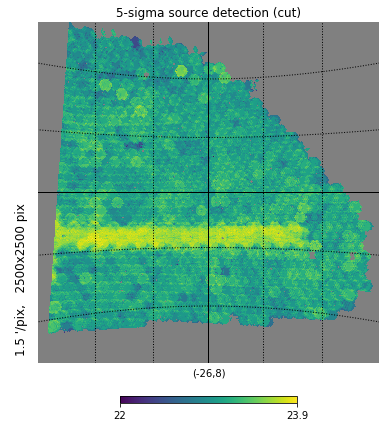

In [22]:
hp.gnomview(mg, flip='astro', xsize=2500, rot=(-26., 8.), nest=True, title='5-sigma source detection (cut)')
hp.graticule(dpar=10.)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/08April2021/HEALPix-350to360-5sig.pdf')
plt.show()


# hp.gnomview(mg, flip='astro', xsize=4000, ysize=3400, rot=(38,8), max=0.8, nest=True, title='BIN0-Median g trans')
# hp.cartview(mg, flip='astro', xsize=225, rot=(38,8), max=0.8, nest=True, title='BIN0-Median g trans')
# hp.mollview(mg, flip='astro', xsize=225, rot=(38,8), max=0.8, nest=True, title='BIN0-Median g trans')
# hp.graticule(dpar=10.)
# plt.show()



percentile:  22.968789201924228


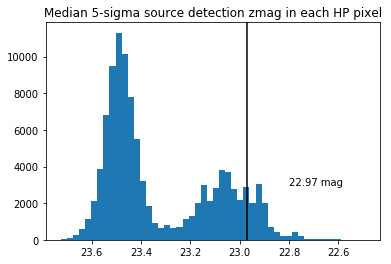

23.432357855587178


In [44]:
# This section isolates the top 98 percent brightest sources in zmag. array_z is a map of median values for zmag for
# each HEALPix pixel.

zmag = array_g[np.where(array_g != -1)]

# sort zmag array
sort_zmag = np.sort(zmag)
# find 90th percentile value
cutlen_z2 = np.percentile(sort_zmag, 10)
print('percentile: ', cutlen_z2)

plt.hist(array_g[np.where(array_g != -1)], bins=50)
plt.title("Median 5-sigma source detection zmag in each HP pixel")
plt.axvline(cutlen_z2, c='black')
plt.gca().invert_xaxis()
plt.text(22.8,3000, '{} mag'.format(round(cutlen_z2,2), fontsize=12))
plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/08April2021/hist-350to360-5sig.pdf')
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/08April2021/hist-bin3-5sig.pdf')

plt.show()

print(np.median(array_g[np.where(array_g != -1)]))


In [26]:
ra_BKGa = ra_BKG3[np.where((ra_BKG3 > 350.) & (ra_BKG3 < 360.) & (dec_BKG3 > -15.) & (dec_BKG3 < 20.))]
dec_BKGa = dec_BKG3[np.where((ra_BKG3 > 350.) & (ra_BKG3 < 360.) & (dec_BKG3 > -15.) & (dec_BKG3 < 20.))]
trans_g_BKGa = trans_g_BKG3[np.where((ra_BKG3 > 350.) & (ra_BKG3 < 360.) & (dec_BKG3 > -15.) & (dec_BKG3 < 20.))]

# ra_BKGb = ra_BKG3[np.where((ra_BKG3 > 350.) & (ra_BKG3 < 360.) & (dec_BKG3 > -15.) & (dec_BKG3 < 0.))]
# dec_BKGb = dec_BKG3[np.where((ra_BKG3 > 350.) & (ra_BKG3 < 360.) & (dec_BKG3 > -15.) & (dec_BKG3 < 0.))]
# trans_g_BKGb = trans_g_BKG3[np.where((ra_BKG3 > 350.) & (ra_BKG3 < 360.) & (dec_BKG3 > -15.) & (dec_BKG3 < 0.))]

ra_BKGb = ra_BKG3[np.where((ra_BKG3 > 320.) & (ra_BKG3 < 330.) & (dec_BKG3 > -15.) & (dec_BKG3 < 10.))]
dec_BKGb = dec_BKG3[np.where((ra_BKG3 > 320.) & (ra_BKG3 < 330.) & (dec_BKG3 > -15.) & (dec_BKG3 < 10.))]
trans_g_BKGb = trans_g_BKG3[np.where((ra_BKG3 > 320.) & (ra_BKG3 < 330.) & (dec_BKG3 > -15.) & (dec_BKG3 < 10.))]

ra_BKGc = ra_BKG3[np.where((ra_BKG3 > 330.) & (ra_BKG3 < 340.) & (dec_BKG3 > 10.) & (dec_BKG3 < 30.))]
dec_BKGc = dec_BKG3[np.where((ra_BKG3 > 330.) & (ra_BKG3 < 340.) & (dec_BKG3 > 10.) & (dec_BKG3 < 30.))]
trans_g_BKGc = trans_g_BKG3[np.where((ra_BKG3 > 330.) & (ra_BKG3 < 340.) & (dec_BKG3 > 10.) & (dec_BKG3 < 30.))]



In [64]:
zmaga = -2.5 * (np.log10(5./np.sqrt(galdepth_BKG3a[np.where(galdepth_BKG3a > 0.)])) - 9.)

print(len(galdepth_BKG3a[np.where(galdepth_BKG3a > 0.)]))
print(len(zmaga))

# plt.hist(zmaga)
# plt.show()

fraca = len(zmaga[np.where(zmaga <= 22.7)])/len(zmaga) * 100.
print(fraca)
print()

zmagb = -2.5 * (np.log10(5./np.sqrt(galdepth_BKG3b[np.where(galdepth_BKG3b > 0.)])) - 9.)

print(len(galdepth_BKG3b))
print(len(zmagb))

fracb = len(zmagb[np.where(zmagb <= 22.7)])/len(zmagb) * 100.

print(fracb)
print()

zmagc = -2.5 * (np.log10(5./np.sqrt(galdepth_BKG3c[np.where(galdepth_BKG3c > 0.)])) - 9.)

print(len(galdepth_BKG3c))
print(len(zmagc))

fracc = len(zmagc[np.where(zmagc <= 22.7)])/len(zmagc) * 100.
print(fracc)


11801206
11801206
2.996880149367785

7173047
7172655
5.301384215468331

16289256
16287376
2.2335028060996445


In [30]:
# Make HEALPix map using just RA/Dec; end up with a density plot

nside = 1024
npixel = hp.nside2npix(nside)

# ra_cut = ra[np.where(zmag <= 21.5)]
# dec_cut = dec[np.where(zmag <= 21.5)]

# Convert ra/dec into theta/phi
theta = []
phi = []

for i in range(len(ra_BKGc)):
    theta.append(np.radians(90. - dec_BKGc[i]))
    phi.append(np.radians(ra_BKGc[i]))

print('length phi: ', len(phi))
# Convert angles theta and phi to pixel numbers
pixnums = hp.ang2pix(nside, theta, phi, nest=True)
print('pixnums: ', pixnums)
print(pixnums[0])
print('length pixnums: ', len(pixnums))


# Create a HEALPix map from pix
mapp = np.bincount(pixnums, minlength=npixel)
# print('map where ne 0: ', mapp[np.where(mapp > 0)])
# print('length map == 0: ', len(mapp[np.where(mapp == 0)]))
# print('length map: ', len(mapp))

# masked_map = np.zeros(len(mapp))
# masked_map[(mapp == 0)] = 1

# m = hp.ma(mapp)
# m.mask = masked_map

length phi:  7173047
pixnums:  [4971395 4971394 4971395 ... 3442153 3442514 3442501]
4971395
length pixnums:  7173047


In [31]:
# This section maps various values of the galaxies into a HEALPix map so the result is basically a density map of
# galaxy properties. In this code the new maps are array_g, array_r, and array_z.

# returns indices that would sort the array pixnums
pixorder = np.argsort(pixnums)
# returns sorted unique values of pixnums, indices to reconstruct the original array from the unique array,
# and the number of times each unique value comes up in the original array
pixels, pixinverse, pixcnts = np.unique(pixnums, return_inverse=True, return_counts=True)

# print(len(pixnums))
# print('----')
# print(pixorder)
# print('----')
# print(len(pixels))
# print('----')
# print(pixcnts)
# inserts a zero in the zeroth index space, moving all other values down the line
pixcnts = np.insert(pixcnts, 0, 0)
# calculates the cumulative sum of the values in pixcnts
pixcnts = np.cumsum(pixcnts)
# print(pixcnts)

# This seems like a weird thing to do, but this is why: pixnums is an array of pixel numbers that correspond to a
# galaxy. There are many galaxies per pixel, so the individual pixnum will repeat. pixcnts is the number of times
# each unique value appears in pixnums. pixorder is the array of indices that would sort pixnums. The loop below makes
# a map of median values per pixel for any desired characteristic. In the loop, inds is the index array of galaxies
# that show up in a pixel (the pixnum values). It uses the range set by pixcnts to determine which index from
# pixorder is used. In the loop, pix is the pixel number inds belongs in.

array_g = np.full(npixel, -1.)
array_r = np.full(npixel, -1.)
array_z = np.full(npixel, -1.)
pix = []
for i in range(len(pixcnts)-1):
# for i in range(1):
    inds = pixorder[pixcnts[i]:pixcnts[i+1]]
#     print(inds)
    pix = pixnums[inds][0]
#     print(pix)
    array_g[pix] = np.median(trans_g_BKGc[inds])
#     array_r[pix] = np.median(zmag[inds])
#     array_z[pix] = np.median(zmag_BKG0[inds])
    # array_g[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_g[inds]))) - 9.)
    # array_r[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_r[inds]))) - 9.)
    # array_z[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_z[inds]))) - 9.)

# print(array_g[array_g != -1])
# print(array_r[array_r != -1])
# print(array_z[array_z != -1])

masked_map_g = np.zeros(len(array_g))
masked_map_g[(array_g == -1.)] = 1

mg = hp.ma(array_g)
mg.mask = masked_map_g
# #
# # masked_map_r = np.zeros(len(array_r))
# # masked_map_r[(array_r == -1.)] = 1
# #
# # mr = hp.ma(array_r)
# # mr.mask = masked_map_r

# masked_map_z = np.zeros(len(array_z))
# masked_map_z[(array_z == -1.)] = 1

# mz = hp.ma(array_z)
# mz.mask = masked_map_z

# # hp.gnomview(mg, xsize=225, ysize=225, rot=(-116.5, 9.), flip='geo', nest=True, title='Median gmag (nobs >= 2)')
# # plt.show()
# #
# # hp.gnomview(mr, xsize=225, ysize=225, rot=(-116.5, 9.), flip='geo', nest=True, title='Median rmag (nobs >= 2)')
# # plt.show()

# This HEALPix image shows the median zmag in each pixel

# hp.gnomview(mg, flip='astro', xsize=4000, ysize=3400, rot=(38,8), max=0.8, nest=True, title='BIN0-Median g trans')
# hp.graticule()
# hp.projector.GnomonicProj.get_center(lonlat=True)
# # plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-g-trans-bin0.pdf')
# plt.show()

52.366867267221544 127.63313273277844 -37.633132732778456 37.633132732778456
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 10 deg 0.00'.


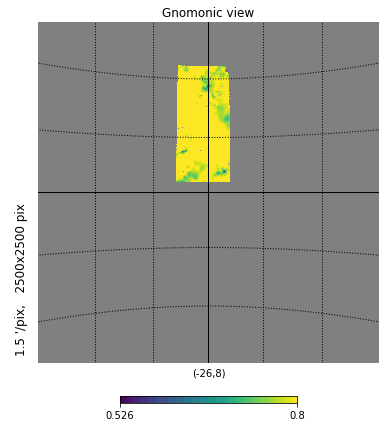

In [32]:
hp.gnomview(mg, flip='astro', xsize=2500, max=0.8, rot=(-26., 8.), nest=True)
hp.graticule(dpar=10.)
plt.savefig('/Users/mtownsend/Desktop/bin3-cut-c.pdf')
plt.show()




In [34]:
# This section isolates the top 98 percent brightest sources in zmag. array_z is a map of median values for zmag for
# each HEALPix pixel.

# sort zmag array
sort_zmag = np.sort(zmag_BKG3)
# find 90th percentile value
cutlen_z2 = np.percentile(sort_zmag, 90)
nz1 = np.rint(cutlen_z1)
print('nz1 = ', nz1)
print('percentile: ', cutlen_z2)

ra90 = ra_BKG3[np.where(zmag_BKG3 <= cutlen_z2)]
dec90 = dec_BKG3[np.where(zmag_BKG3 <= cutlen_z2)]

phi98 = []
theta98 = []

for i in range(len(ra90)):
    theta98.append(np.radians(90. - dec90[i]))
    phi98.append(np.radians(ra90[i]))

# Convert angles theta and phi to pixel numbers
pixnums98 = hp.ang2pix(nside, theta98, phi98, nest=True)

# Create a HEALPix map from pix
density_map98 = np.bincount(pixnums98, minlength=npixel)



sorted array;  [18.4701767  18.71933174 18.8137455  ... 25.18280029 26.97361755
 27.16163826]
nz1 =  62160.0
percentile:  23.644655990600597


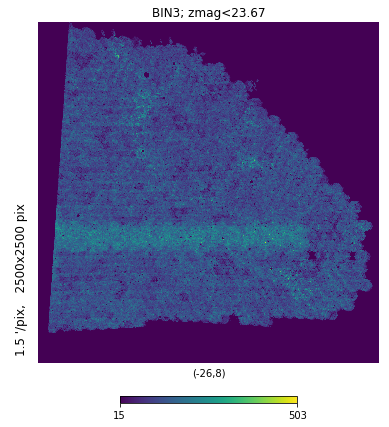

In [42]:
# Plot mapp
hp.gnomview(density_map98, flip='astro', xsize=2500, min=15, rot=(-26., 8.), nest=True, title='BIN3; zmag<23.67')
plt.savefig("/Users/mtownsend/Desktop/zmag_cut_bin3.pdf")
plt.show()

# plt.title("Median z-mag Distribution (bin3)")
# plt.hist(zmag_BKG3, bins=50, color='blue', alpha=0.5)
# plt.xlabel(r'$median$ $zmag$')
# plt.ylabel(r'$counts$')
# plt.xlim(15., 26.)
# plt.gca().invert_xaxis()
# plt.axvline(x=cutlen_z2, linewidth=1, color='black')
# plt.text(23.5,50000, '{} mag'.format(round(cutlen_z2,2), fontsize=12))
# plt.savefig("/Users/mtownsend/Desktop/zmag_cut_bin3.pdf")
# plt.show()

# plt.title("zmag Distribution for LRGs")
# plt.hist(zmag_LRG, bins=50, color='blue', alpha=0.5)
# plt.xlabel(r'$zmag$')
# plt.ylabel(r'$counts$')
# # plt.xlim(19., 24.)
# plt.gca().invert_xaxis()
# # plt.axvline(x=reverse_sorted_z[np.int64(nz1)], linewidth=1, color='black')
# # plt.text(22.4, 450, '{} mag'.format(np.around(reverse_sorted_z[np.int64(nz1)], decimals=2)), fontsize=8)
# # plt.savefig("/Users/mtownsend/Desktop/zmag_cut.pdf")
# plt.show()


In [32]:
print(len(ra90))
print(len(ra_BKG3))

82701960
91891067


In [5]:
# do zmag limits for likely catalog cuts

ra_dat3a = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/raBKG_320to330-dr9.npz')
ra_BKG3a = ra_dat3a['arr_0']
print(len(ra_BKG3a))
print('ra done')

dec_dat3a = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/decBKG_320to330-dr9.npz')
dec_BKG3a = dec_dat3a['arr_0']
print(len(dec_BKG3a))
print('dec done')

galdepth_dat3a = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/galdepth_z_BKG_320to330-dr9.npz')
galdepth_BKG3a = galdepth_dat3a['arr_0']
print(len(galdepth_BKG3a))
print('zmag done')



ra_dat3b = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/raBKG_330to340-dr9.npz')
ra_BKG3b = ra_dat3b['arr_0']
print(len(ra_BKG3b))
print('ra done')

dec_dat3b = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/decBKG_330to340-dr9.npz')
dec_BKG3b = dec_dat3b['arr_0']
print(len(dec_BKG3b))
print('dec done')

galdepth_dat3b = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/galdepth_z_BKG_330to340-dr9.npz')
galdepth_BKG3b = galdepth_dat3b['arr_0']
print(len(galdepth_BKG3b))
print('zmag done')



ra_dat3c = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/raBKG_350to360-dr9.npz')
ra_BKG3c = ra_dat3c['arr_0']
print(len(ra_BKG3c))
print('ra done')

dec_dat3c = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/decBKG_350to360-dr9.npz')
dec_BKG3c = dec_dat3c['arr_0']
print(len(dec_BKG3c))
print('dec done')

galdepth_dat3c = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/BKG/galdepth_z_BKG_350to360-dr9.npz')
galdepth_BKG3c = galdepth_dat3c['arr_0']
print(len(galdepth_BKG3c))
print('zmag done')



12303351
ra done
12303351
dec done
12303351
zmag done
7529769
ra done
7529769
dec done
7529769
zmag done
16738686
ra done
16738686
dec done
16738686
zmag done


In [10]:
# Make HEALPix map using just RA/Dec; end up with a density plot

nside = 1024
npixel = hp.nside2npix(nside)

# ra_cut = ra[np.where(zmag <= 21.5)]
# dec_cut = dec[np.where(zmag <= 21.5)]

# Convert ra/dec into theta/phi
theta3a = []
phi3a = []

for i in range(len(ra_BKG3a)):
    theta3a.append(np.radians(90. - dec_BKG3a[i]))
    phi3a.append(np.radians(ra_BKG3a[i]))

print('length phi: ', len(phi3a))
# Convert angles theta and phi to pixel numbers
pixnums3a = hp.ang2pix(nside, theta3a, phi3a, nest=True)
print('pixnums: ', pixnums3a)
print(pixnums3a[0])
print('length pixnums: ', len(pixnums))


# Create a HEALPix map from pix
mapp3a = np.bincount(pixnums3a, minlength=npixel)



# Convert ra/dec into theta/phi
theta3b = []
phi3b = []

for i in range(len(ra_BKG3b)):
    theta3b.append(np.radians(90. - dec_BKG3b[i]))
    phi3b.append(np.radians(ra_BKG3b[i]))

print('length phi: ', len(phi3b))
# Convert angles theta and phi to pixel numbers
pixnums3b = hp.ang2pix(nside, theta3b, phi3b, nest=True)
print('pixnums: ', pixnums3b)
print(pixnums3b[0])
print('length pixnums: ', len(pixnums3b))


# Create a HEALPix map from pix
mapp3b = np.bincount(pixnums3b, minlength=npixel)



# Convert ra/dec into theta/phi
theta3c = []
phi3c = []

for i in range(len(ra_BKG3c)):
    theta3c.append(np.radians(90. - dec_BKG3c[i]))
    phi3c.append(np.radians(ra_BKG3c[i]))

print('length phi: ', len(phi3c))
# Convert angles theta and phi to pixel numbers
pixnums3c = hp.ang2pix(nside, theta3c, phi3c, nest=True)
print('pixnums: ', pixnums3c)
print(pixnums3c[0])
print('length pixnums: ', len(pixnums3c))


# Create a HEALPix map from pix
mapp3c = np.bincount(pixnums3c, minlength=npixel)

length phi:  12303351
pixnums:  [4865987 4865996 4865984 ... 3165277 3165264 3163898]
4865987
length pixnums:  12303351
length phi:  7529769
pixnums:  [4971395 4971394 4971395 ... 3442153 3442514 3442501]
4971395
length pixnums:  7529769
length phi:  16738686
pixnums:  [4803286 4803287 4803464 ... 5125396 5119929 5119931]
4803286
length pixnums:  16738686


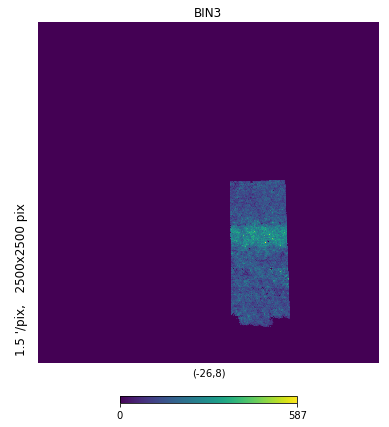

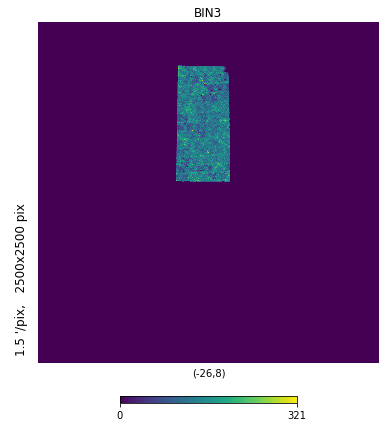

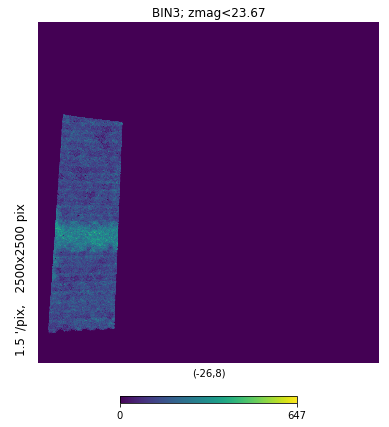

In [11]:
# Plot mapp
hp.gnomview(mapp3a, flip='astro', xsize=2500, rot=(-26., 8.), nest=True, title='BIN3')
hp.gnomview(mapp3b, flip='astro', xsize=2500, rot=(-26., 8.), nest=True, title='BIN3')
hp.gnomview(mapp3c, flip='astro', xsize=2500, rot=(-26., 8.), nest=True, title='BIN3; zmag<23.67')

# plt.savefig("/Users/mtownsend/Desktop/zmag_cut_bin3.pdf")
plt.show()

In [16]:
# This section maps various values of the galaxies into a HEALPix map so the result is basically a density map of
# galaxy properties. In this code the new maps are array_g, array_r, and array_z.

# returns indices that would sort the array pixnums
pixorder = np.argsort(pixnums3a)
# returns sorted unique values of pixnums, indices to reconstruct the original array from the unique array,
# and the number of times each unique value comes up in the original array
pixels, pixinverse, pixcnts = np.unique(pixnums3a, return_inverse=True, return_counts=True)

# print(len(pixnums))
# print('----')
# print(pixorder)
# print('----')
# print(len(pixels))
# print('----')
# print(pixcnts)
# inserts a zero in the zeroth index space, moving all other values down the line
pixcnts = np.insert(pixcnts, 0, 0)
# calculates the cumulative sum of the values in pixcnts
pixcnts = np.cumsum(pixcnts)
# print(pixcnts)

# This seems like a weird thing to do, but this is why: pixnums is an array of pixel numbers that correspond to a
# galaxy. There are many galaxies per pixel, so the individual pixnum will repeat. pixcnts is the number of times
# each unique value appears in pixnums. pixorder is the array of indices that would sort pixnums. The loop below makes
# a map of median values per pixel for any desired characteristic. In the loop, inds is the index array of galaxies
# that show up in a pixel (the pixnum values). It uses the range set by pixcnts to determine which index from
# pixorder is used. In the loop, pix is the pixel number inds belongs in.

array_g = np.full(npixel, -1.)
array_r = np.full(npixel, -1.)
array_z = np.full(npixel, -1.)
pix = []
for i in range(len(pixcnts)-1):
# for i in range(1):
    inds = pixorder[pixcnts[i]:pixcnts[i+1]]
#     print(inds)
    pix = pixnums3a[inds][0]
#     print(pix)
    array_g[pix] = -2.5 * (np.log10(5./np.sqrt(np.median(galdepth_BKG3a[inds]))) - 9.)
#     array_r[pix] = np.median(trans_r_BKG1[inds])
#     array_z[pix] = np.median(zmag_BKG1[inds])
    # array_g[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_g[inds]))) - 9.)
    # array_r[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_r[inds]))) - 9.)
    # array_z[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_z[inds]))) - 9.)

# print(array_g[array_g != -1])
# print(array_r[array_r != -1])
# print(array_z[array_z != -1])

masked_map_g = np.zeros(len(array_g))
masked_map_g[(array_g == -1.)] = 1

mg3a = hp.ma(array_g)
mg3a.mask = masked_map_g

In [19]:
# This section maps various values of the galaxies into a HEALPix map so the result is basically a density map of
# galaxy properties. In this code the new maps are array_g, array_r, and array_z.

# returns indices that would sort the array pixnums
pixorder = np.argsort(pixnums3b)
# returns sorted unique values of pixnums, indices to reconstruct the original array from the unique array,
# and the number of times each unique value comes up in the original array
pixels, pixinverse, pixcnts = np.unique(pixnums3b, return_inverse=True, return_counts=True)

# print(len(pixnums))
# print('----')
# print(pixorder)
# print('----')
# print(len(pixels))
# print('----')
# print(pixcnts)
# inserts a zero in the zeroth index space, moving all other values down the line
pixcnts = np.insert(pixcnts, 0, 0)
# calculates the cumulative sum of the values in pixcnts
pixcnts = np.cumsum(pixcnts)
# print(pixcnts)

# This seems like a weird thing to do, but this is why: pixnums is an array of pixel numbers that correspond to a
# galaxy. There are many galaxies per pixel, so the individual pixnum will repeat. pixcnts is the number of times
# each unique value appears in pixnums. pixorder is the array of indices that would sort pixnums. The loop below makes
# a map of median values per pixel for any desired characteristic. In the loop, inds is the index array of galaxies
# that show up in a pixel (the pixnum values). It uses the range set by pixcnts to determine which index from
# pixorder is used. In the loop, pix is the pixel number inds belongs in.

array_g = np.full(npixel, -1.)
array_r = np.full(npixel, -1.)
array_z = np.full(npixel, -1.)
pix = []
for i in range(len(pixcnts)-1):
# for i in range(1):
    inds = pixorder[pixcnts[i]:pixcnts[i+1]]
#     print(inds)
    pix = pixnums3b[inds][0]
#     print(pix)
    array_g[pix] = -2.5 * (np.log10(5./np.sqrt(np.median(galdepth_BKG3b[inds]))) - 9.)
#     array_r[pix] = np.median(trans_r_BKG1[inds])
#     array_z[pix] = np.median(zmag_BKG1[inds])
    # array_g[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_g[inds]))) - 9.)
    # array_r[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_r[inds]))) - 9.)
    # array_z[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_z[inds]))) - 9.)

# print(array_g[array_g != -1])
# print(array_r[array_r != -1])
# print(array_z[array_z != -1])

masked_map_g = np.zeros(len(array_g))
masked_map_g[(array_g == -1.)] = 1

mg3b = hp.ma(array_g)
mg3b.mask = masked_map_g

In [22]:
# This section maps various values of the galaxies into a HEALPix map so the result is basically a density map of
# galaxy properties. In this code the new maps are array_g, array_r, and array_z.

# returns indices that would sort the array pixnums
pixorder = np.argsort(pixnums3c)
# returns sorted unique values of pixnums, indices to reconstruct the original array from the unique array,
# and the number of times each unique value comes up in the original array
pixels, pixinverse, pixcnts = np.unique(pixnums3c, return_inverse=True, return_counts=True)

# print(len(pixnums))
# print('----')
# print(pixorder)
# print('----')
# print(len(pixels))
# print('----')
# print(pixcnts)
# inserts a zero in the zeroth index space, moving all other values down the line
pixcnts = np.insert(pixcnts, 0, 0)
# calculates the cumulative sum of the values in pixcnts
pixcnts = np.cumsum(pixcnts)
# print(pixcnts)

# This seems like a weird thing to do, but this is why: pixnums is an array of pixel numbers that correspond to a
# galaxy. There are many galaxies per pixel, so the individual pixnum will repeat. pixcnts is the number of times
# each unique value appears in pixnums. pixorder is the array of indices that would sort pixnums. The loop below makes
# a map of median values per pixel for any desired characteristic. In the loop, inds is the index array of galaxies
# that show up in a pixel (the pixnum values). It uses the range set by pixcnts to determine which index from
# pixorder is used. In the loop, pix is the pixel number inds belongs in.

array_g = np.full(npixel, -1.)
array_r = np.full(npixel, -1.)
array_z = np.full(npixel, -1.)
pix = []
for i in range(len(pixcnts)-1):
# for i in range(1):
    inds = pixorder[pixcnts[i]:pixcnts[i+1]]
#     print(inds)
    pix = pixnums3c[inds][0]
#     print(pix)
    array_g[pix] = -2.5 * (np.log10(5./np.sqrt(np.median(galdepth_BKG3c[inds]))) - 9.)
#     array_r[pix] = np.median(trans_r_BKG1[inds])
#     array_z[pix] = np.median(zmag_BKG1[inds])
    # array_g[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_g[inds]))) - 9.)
    # array_r[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_r[inds]))) - 9.)
    # array_z[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_z[inds]))) - 9.)

# print(array_g[array_g != -1])
# print(array_r[array_r != -1])
# print(array_z[array_z != -1])

masked_map_g = np.zeros(len(array_g))
masked_map_g[(array_g == -1.)] = 1

mg3c = hp.ma(array_g)
mg3c.mask = masked_map_g

/Users/mtownsend/anaconda/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide


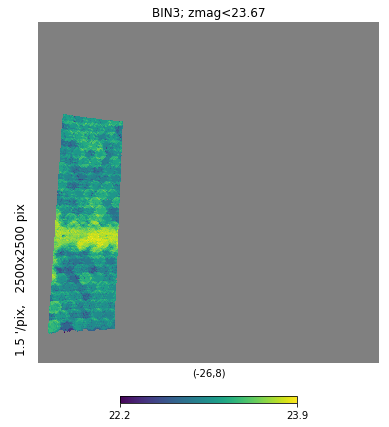

In [23]:
# Plot mapp
# hp.gnomview(mg3a, flip='astro', xsize=2500, rot=(-26., 8.), nest=True, title='BIN3')
# hp.gnomview(mg3b, flip='astro', xsize=2500, rot=(-26., 8.), nest=True, title='BIN3')
hp.gnomview(mg3c, flip='astro', xsize=2500, rot=(-26., 8.), nest=True, title='BIN3; zmag<23.67')

# plt.savefig("/Users/mtownsend/Desktop/zmag_cut_bin3.pdf")
plt.show()

percentile:  23.478059321338964


ValueError: supplied range of [-inf, 23.85032455644373] is not finite

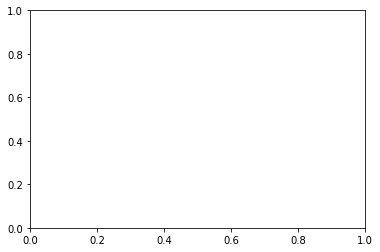

In [24]:
# This section isolates the top 98 percent brightest sources in zmag. array_z is a map of median values for zmag for
# each HEALPix pixel.

zmag = array_g[np.where(array_g != -1)]

# sort zmag array
sort_zmag = np.sort(zmag)
# find 90th percentile value
cutlen_z2 = np.percentile(sort_zmag, 90)
print('percentile: ', cutlen_z2)

plt.hist(array_g[np.where(array_g != -1)], bins=50)
plt.title("Median 5-sigma source detection zmag in each HP pixel")
plt.axvline(cutlen_z2, c='black')
plt.gca().invert_xaxis()
plt.text(22.5,4000, '{} mag'.format(round(cutlen_z2,2), fontsize=12))
plt.show()

print(np.median(array_g[np.where(array_g != -1)]))
